# <center>Bad Bank Behavior<br>Analyzing Bank Mortgage during the 2007 Housing Bubble</center>  

<center>Michael Siebel</center>
<center>August 2020</center>
<br>
    
## <center>Data Wrangling Script</center>

# Purpose
<br>

> ETL data from: <br>
1) Fannie Mae Loan Acquistion and Performance Data [Individual Mortgage Loans], <br>
2) Past Fannie Mae Loan Acquistion Data [Changes in Loan Amounts], <br>
3) U.S. Census Bureau, Small Area Estimates Branch [Median Household Income by County], <br>
4) Federal Reserve Economic Data (FRED) [Macroeconomic Data related to the Housing Market], <br>
5) Federal Deposit Insurance Corporation (FDIC) Data [Information on FDIC-backed Banks]

***

# Load Functions

In [1]:
%run Functions.ipynb
pd.set_option("display.max_columns", 999)

***

# Load Fannie Mae Data

In [2]:
# Import packages
import os
import glob

# Collect file names
fld = '..\Data\\'
x = []
for file in os.listdir(fld):
    filename = os.fsdecode(file)
    if filename.startswith("Acquisition_2007Q"): 
        x.append(fld + filename)

y = []
for file in os.listdir(fld):
    filename = os.fsdecode(file)
    if filename.startswith("Performance_2007Q"): 
        y.append(fld + filename)

# Load data
df_acq = pd.DataFrame()
df_per = pd.DataFrame()
for i in range(len(x)):
    acq, per = load_data(x[i], y[i])
    acq['File Year'], per['File Year'] = x[i][20:24], x[i][20:24]
    acq['File Quarter'], per['File Quarter'] = x[i][24:26], x[i][24:26]   
    df_acq = pd.concat([df_acq, acq], ignore_index=True)
    df_per = pd.concat([df_per, per], ignore_index=True)
    print('..Loaded year', x[i][20:24], 'quarter', x[i][24:26])

..Loaded year 2007 quarter Q1
..Loaded year 2007 quarter Q2
..Loaded year 2007 quarter Q3
..Loaded year 2007 quarter Q4


In [3]:
# Drop unnecessary variables
## remove Property Type, it only had one value    
df_acq = df_acq.drop(labels=['Product Type'], axis=1)

## remove Original Loan-to-Value (LTV) and use Original Combine Loan-to-Value (CLTV)
df_acq = df_acq.drop(labels=['Original Loan-to-Value (LTV)'], axis=1)
    
## remove First Payment as this is of no value
df_acq = df_acq.drop(labels=['First Payment'], axis=1)

## remove Number of Units as it lacks data variation
df_acq = df_acq.drop(labels=['Number of Units'], axis=1)

## remove Relocation Mortgage Indicator
df_acq = df_acq.drop(labels=['Relocation Mortgage Indicator'], axis=1)

***

# Merge Target from Performance Data


The number of features is:
23

The number of observations is:
1246499


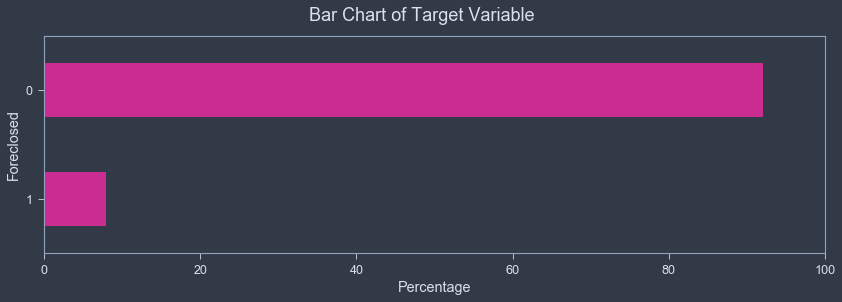

Frequency of Foreclosures
0    1143652
1     102847
Name: Foreclosed, dtype: int64

Percentage of Foreclosures
0    92
1     8
Name: Foreclosed, dtype: int32



In [4]:
# Create Target Variable with Merge
df = merge_df(df_acq, df_per)

print('\nThe number of features is:\n', df.shape[1], sep='')
print('\nThe number of observations is:\n', df.shape[0], sep='')
target_values(df['Foreclosed'], data=True)

In [5]:
# Drop U.S. Terroritories due to missing data
df = df[df['Property State'] != 'PR']
df = df[df['Property State'] != 'GU']
df = df[df['Property State'] != 'VI']

df.head(10)

,Loan ID,Origination Channel,Bank,Original Interest Rate,Original Mortgage Amount,Original Loan Term,Original Date,Original Combined Loan-to-Value (CLTV),Number of Borrowers,Original Debt to Income Ratio,Credit Score,First Time Home Buyer,Loan Purpose,Property Type,Occupancy Type,Property State,Zip Code,Mortgage Insurance %,Co-Borrower Credit Score,Mortgage Insurance Type,File Year,File Quarter,Foreclosed
0,100001461640,R,"PNC BANK, N.A.",6.250,137000,360,01/2007,56.0,2.0,37.0,741.0,N,C,SF,P,MI,486,NaN,734.0,NaN,2007,Q1,1
1,100015135004,R,SUNTRUST MORTGAGE INC.,6.000,116000,360,02/2007,80.0,2.0,11.0,796.0,N,R,SF,S,GA,302,NaN,762.0,NaN,2007,Q1,0
2,100015306566,C,"CITIMORTGAGE, INC.",6.375,58000,180,02/2007,78.0,2.0,30.0,710.0,N,R,SF,P,IN,465,NaN,NaN,NaN,2007,Q1,0
3,100015319835,C,"BANK OF AMERICA, N.A.",6.125,353000,360,12/2006,80.0,2.0,28.0,778.0,N,R,SF,P,MA,21,NaN,656.0,NaN,2007,Q1,0
4,100030521552,C,"GMAC MORTGAGE, LLC",5.875,385000,360,12/2006,70.0,2.0,50.0,720.0,N,C,SF,P,CA,917,NaN,700.0,NaN,2007,Q1,0
5,100034251351,R,OTHER,6.250,117000,360,03/2007,90.0,2.0,41.0,753.0,N,P,SF,P,OH,449,17.0,743.0,1.0,2007,Q1,0
6,100036401006,R,OTHER,5.750,200000,360,01/2007,46.0,2.0,25.0,674.0,N,C,SF,P,CT,60,NaN,763.0,NaN,2007,Q1,0
7,100037298334,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6.375,219000,360,12/2006,92.0,2.0,27.0,749.0,Y,P,PU,P,NC,282,NaN,NaN,NaN,2007,Q1,0
8,100039008927,C,"CITIMORTGAGE, INC.",6.375,198000,360,12/2006,54.0,1.0,13.0,777.0,N,C,SF,S,CA,961,NaN,NaN,NaN,2007,Q1,0
9,100048042494,R,OTHER,5.875,55000,180,03/2007,37.0,1.0,41.0,619.0,N,C,SF,P,AR,727,NaN,NaN,NaN,2007,Q1,0


In [6]:
# Dates
## Pre-file date values indicate a mortgage loan refinnanced during the date value
df['Original Date'].value_counts()

10/2007    117700
05/2007    114280
06/2007    108604
08/2007    107560
09/2007    100756
            ...  
11/2000         1
11/1999         1
05/1999         1
10/2000         1
04/2004         1
Name: Original Date, Length: 101, dtype: int64

***

# Fannie Mae Feature Recodes

In [7]:
# Date Variables
df = df.sort_values(by=['Original Date'])
df['Month'] = df['Original Date'].apply(lambda x: x.split('/')[0].strip()).apply(str)
df['Year'] = df['Original Date'].apply(lambda x: x.split('/')[1].strip()).apply(str)
df['Year'].value_counts()

2007    1106679
2006     133008
2005        774
2002        159
2001        132
2003        106
2004         71
1999         28
2000         11
Name: Year, dtype: int64

In [8]:
# Co-Borrower Credit Score
df['Harmonized Credit Score'] = ( df.loc[df['Co-Borrower Credit Score'].notnull(), 'Co-Borrower Credit Score'] * 0.5 ) \
                                  + ( df['Credit Score'].loc[df['Co-Borrower Credit Score'].notnull()] * 0.5 ) 
df.loc[df['Co-Borrower Credit Score'].isnull(), 'Harmonized Credit Score'] = \
                    df.loc[df['Co-Borrower Credit Score'].isnull(), 'Credit Score']  
df.loc[df['Harmonized Credit Score'].isnull(), 'Harmonized Credit Score'] = \
                    df.loc[df['Harmonized Credit Score'].isnull(), 'Credit Score'] 

print(df[['Harmonized Credit Score', 'Credit Score', 'Co-Borrower Credit Score']].head(10))
df = df.drop(labels=['Credit Score', 'Co-Borrower Credit Score'], axis=1)

         Harmonized Credit Score  Credit Score  Co-Borrower Credit Score
1213785                    794.0         794.0                     794.0
587882                     774.5         774.0                     775.0
1194659                    708.5         693.0                     724.0
175492                     628.0         628.0                       NaN
1143614                    787.5         785.0                     790.0
617838                     791.5         799.0                     784.0
386304                     779.5         779.0                     780.0
21969                      674.0         674.0                       NaN
86221                      475.0         475.0                       NaN
715353                     773.0         773.0                       NaN


In [9]:
# Mortgage Insurance %
df['Mortgage Insurance %'] = np.where(df['Mortgage Insurance %'].isnull(), \
                                      0, df['Mortgage Insurance %'])
df.loc[df['Mortgage Insurance %']==0, 'Mortgage Insurance Type'].value_counts()

Series([], Name: Mortgage Insurance Type, dtype: int64)

In [10]:
# Mortgage Insurance %
df['Mortgage Insurance %'] = np.where(df['Mortgage Insurance %'].isnull(), \
                                      0, df['Mortgage Insurance %'])
df['Mortgage Insurance %'].describe()

count    1.240968e+06
mean     3.975473e+00
std      9.098006e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.000000e+01
Name: Mortgage Insurance %, dtype: float64

In [11]:
# Collapse Refinance
df['Loan Purpose'] = np.where(df['Loan Purpose'] != 'P', 1, df['Loan Purpose'])
df['Loan Purpose'] = df['Loan Purpose'].replace('P', 0)
df['Loan Purpose'].value_counts()

1    766877
0    474091
Name: Loan Purpose, dtype: int64

In [12]:
# Recode Number of Borrowers
## Single Borrower binary
## More than one borrower is 0
df['Number of Borrowers'] = df['Number of Borrowers'].where(df['Number of Borrowers'] == 1, 0)
df = df.rename(columns={'Number of Borrowers': 'Single Borrower'})
df['Single Borrower'].value_counts()

0.0    665771
1.0    575197
Name: Single Borrower, dtype: int64

***

# Group Banks

Goal is to keep bank values ~10,000

In [13]:
# Bank Values
df['Bank'].value_counts()

BANK OF AMERICA, N.A.                                   371423
OTHER                                                   213459
CITIMORTGAGE, INC.                                      135536
WELLS FARGO BANK, N.A.                                  101136
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION                88255
GMAC MORTGAGE, LLC                                       75599
PNC BANK, N.A.                                           63726
SUNTRUST MORTGAGE INC.                                   53548
AMTRUST BANK                                             38024
FLAGSTAR CAPITAL MARKETS CORPORATION                     34789
FIRST TENNESSEE BANK NATIONAL ASSOCIATION                28718
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB                  9966
CHASE HOME FINANCE                                        6866
CHASE HOME FINANCE, LLC                                   6830
BISHOPS GATE RESIDENTIAL MORTGAGE TRUST                   3327
GMAC MORTGAGE, LLC (USAA FEDERAL SAVINGS BANK)         

In [14]:
# Recode Bank to keep bank values ~10,000
## Group Small loan banks
Small_Loan = ['BISHOPS GATE RESIDENTIAL MORTGAGE TRUST', 
              'FREEDOM MORTGAGE CORP.', 
              'HSBC BANK USA, NATIONAL ASSOCIATION', 'PHH MORTGAGE CORPORATION (USAA FEDERAL SAVINGS BANK)', 
              'THIRD FEDERAL SAVINGS AND LOAN', 'WELLS FARGO BANK, N.A.']
df = df.replace({'Bank': Small_Loan}, 'SMALL LOAN BANKS')

## Collapse similar banks
Chase = ["CHASE HOME FINANCE (CIE 1)", "CHASE HOME FINANCE, LLC"]
df = df.replace({'Bank': Chase}, 'CHASE HOME FINANCE')
GMAC = ['GMAC MORTGAGE, LLC (USAA FEDERAL SAVINGS BANK)', 'GMAC MORTGAGE, LLC']
df = df.replace({'Bank': GMAC}, 'GMAC MORTGAGE')

# Check updated Bank values
df['Bank'].value_counts()

BANK OF AMERICA, N.A.                        371423
OTHER                                        213459
CITIMORTGAGE, INC.                           135536
SMALL LOAN BANKS                             108890
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION     88255
GMAC MORTGAGE                                 78843
PNC BANK, N.A.                                63726
SUNTRUST MORTGAGE INC.                        53548
AMTRUST BANK                                  38024
FLAGSTAR CAPITAL MARKETS CORPORATION          34789
FIRST TENNESSEE BANK NATIONAL ASSOCIATION     28718
CHASE HOME FINANCE                            15791
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB       9966
Name: Bank, dtype: int64

In [15]:
## 2006 Data
p1 = []
for file in os.listdir(fld):
    filename = os.fsdecode(file)
    if filename.startswith("Acquisition_2006Q"): 
        p1.append(fld + filename)

## 2002 Data
p5 = []
for file in os.listdir(fld):
    filename = os.fsdecode(file)
    if filename.startswith("Acquisition_2002Q"): 
        p5.append(fld + filename)

# Load data
## 2006 Data
df_yr1 = pd.DataFrame()
for i in range(len(p1)):
    yr1, blk = load_data(p1[i])
    yr1['File Year'] = p1[i][20:24]
    yr1['File Quarter'] = p1[i][24:26]
    df_yr1 = pd.concat([df_yr1, yr1], ignore_index=True)
    print('..Loaded year', p1[i][20:24], 'quarter', p1[i][24:26])

print('')
## 2002 Data
df_yr5 = pd.DataFrame()
for i in range(len(p5)):
    yr5, blk = load_data(p5[i])
    yr5['File Year'] = p5[i][20:24]
    yr5['File Quarter'] = p5[i][24:26]
    df_yr5 = pd.concat([df_yr5, yr5], ignore_index=True)
    print('..Loaded year', p5[i][20:24], 'quarter', p5[i][24:26])

..Loaded year 2006 quarter Q1
..Loaded year 2006 quarter Q2
..Loaded year 2006 quarter Q3
..Loaded year 2006 quarter Q4

..Loaded year 2002 quarter Q1
..Loaded year 2002 quarter Q2
..Loaded year 2002 quarter Q3
..Loaded year 2002 quarter Q4


In [16]:
# Aggregate total loans by collapsing by Banks and File Date
Loans2007 = df.groupby(['Bank', 'File Year', 'File Quarter', 'Zip Code']) \
            .agg({'Original Mortgage Amount': 'mean'}).reset_index()
Loans2006 = df_yr1.groupby(['Bank', 'File Year', 'File Quarter', 'Zip Code']) \
            .agg({'Original Mortgage Amount': 'mean'}).reset_index()
Loans2002 = df_yr5.groupby(['Bank', 'File Year', 'File Quarter', 'Zip Code']) \
            .agg({'Original Mortgage Amount': 'mean'}).reset_index()

# 1 Year change in total loans
LoansYr1_Q1 = pd.merge(Loans2007.loc[Loans2007['File Quarter']=='Q1'], 
                       Loans2006.loc[Loans2006['File Quarter']=='Q1', :],
                       on=['Bank', 'Zip Code'], how='left', suffixes=('', ' (Prev)'))    
LoansYr1_Q2 = pd.merge(Loans2007.loc[Loans2007['File Quarter']=='Q2'], 
                       Loans2006.loc[Loans2006['File Quarter']=='Q2', :],
                       on=['Bank', 'Zip Code'], how='left', suffixes=('', ' (Prev)'))    
LoansYr1_Q3 = pd.merge(Loans2007.loc[Loans2007['File Quarter']=='Q3'], 
                       Loans2006.loc[Loans2006['File Quarter']=='Q3', :],
                       on=['Bank', 'Zip Code'], how='left', suffixes=('', ' (Prev)'))    
LoansYr1_Q4 = pd.merge(Loans2007.loc[Loans2007['File Quarter']=='Q4'], 
                       Loans2006.loc[Loans2006['File Quarter']=='Q4', :],
                       on=['Bank', 'Zip Code'], how='left', suffixes=('', ' (Prev)'))    
LoansYr1 = pd.concat([LoansYr1_Q1, LoansYr1_Q2, LoansYr1_Q3, LoansYr1_Q4], axis=0)
LoansYr1.loc[LoansYr1['Original Mortgage Amount (Prev)'].isnull(), 'Original Mortgage Amount (Prev)'] = 0
LoansYr1['Loan Change (1 Year)'] = LoansYr1['Original Mortgage Amount'] \
                                   - LoansYr1['Original Mortgage Amount (Prev)']
LoansYr1 = LoansYr1[['Bank', 'Zip Code', 'File Quarter', 'Loan Change (1 Year)']]
df = pd.merge(df, LoansYr1, on=['Bank', 'Zip Code', 'File Quarter'], how='left', copy=False)
print('Average change in 1 year: $', np.mean(LoansYr1['Loan Change (1 Year)']).round(2))

# 5 year change in total loans
LoansYr5_Q1 = pd.merge(Loans2007.loc[Loans2007['File Quarter']=='Q1'], 
                       Loans2002.loc[Loans2002['File Quarter']=='Q1', :],
                       on=['Bank', 'Zip Code'], how='left', suffixes=('', ' (Prev)'))    
LoansYr5_Q2 = pd.merge(Loans2007.loc[Loans2007['File Quarter']=='Q2'], 
                       Loans2002.loc[Loans2002['File Quarter']=='Q2', :],
                       on=['Bank', 'Zip Code'], how='left', suffixes=('', ' (Prev)'))    
LoansYr5_Q3 = pd.merge(Loans2007.loc[Loans2007['File Quarter']=='Q3'], 
                       Loans2002.loc[Loans2002['File Quarter']=='Q3', :],
                       on=['Bank', 'Zip Code'], how='left', suffixes=('', ' (Prev)'))    
LoansYr5_Q4 = pd.merge(Loans2007.loc[Loans2007['File Quarter']=='Q4'], 
                       Loans2002.loc[Loans2002['File Quarter']=='Q4', :],
                       on=['Bank', 'Zip Code'], how='left', suffixes=('', ' (Prev)'))    
LoansYr5 = pd.concat([LoansYr5_Q1, LoansYr5_Q2, LoansYr5_Q3, LoansYr5_Q4], axis=0)
LoansYr5.loc[LoansYr5['Original Mortgage Amount (Prev)'].isnull(), 'Original Mortgage Amount (Prev)'] = 0
LoansYr5['Loan Change (5 Years)'] = LoansYr5['Original Mortgage Amount'] \
                                    - LoansYr5['Original Mortgage Amount (Prev)']
LoansYr5 = LoansYr5[['Bank', 'Zip Code', 'File Quarter', 'Loan Change (5 Years)']]
df = pd.merge(df, LoansYr5, on=['Bank', 'Zip Code', 'File Quarter'], how='left', copy=False)
print('Average change in 5 years: $', np.mean(LoansYr5['Loan Change (5 Years)']).round(2))

print('Shape:', df.shape)

Average change in 1 year: $ 64178.81
Average change in 5 years: $ 105136.67
Shape: (1240968, 26)


***

# ETL Median Household Income

ETL County-level median household income from U.S. Census

Aggregate on 3-digit zipcode

In [17]:
# Import zipcode median household income
income = pd.read_excel("..\Data\est07all.xls",
                       sheet_name = 'est07ALL', header = 2)
income = income[['Name', 'Median Household Income']]
income = income.rename(columns={'Name': 'County'})

# Import county zipcode crosswalk
crosswalk = pd.read_csv("..\Data\ZIP-COUNTY-FIPS_2017-06.csv",
                        header = 0)
crosswalk = crosswalk[['ZIP', 'COUNTYNAME', 'STCOUNTYFP']]
crosswalk = crosswalk.rename(columns={'ZIP': 'Zip Code', 'COUNTYNAME': 'County', 'STCOUNTYFP': 'FIPS'})
crosswalk['Zip Code'] = crosswalk['Zip Code'].astype(str)
crosswalk['Zip Code'] = crosswalk['Zip Code'].str.slice(start=0, stop=-2)
crosswalk['Zip Code'] = crosswalk['Zip Code'].astype(int)

# Merge
county_level = pd.merge(income, crosswalk, on='County', how='outer')
county_level.head(10)

,County,Median Household Income,Zip Code,FIPS
0,United States,50740.0,NaN,NaN
1,Alabama,40596.0,NaN,NaN
2,Autauga County,50375.0,360.0,1001.0
3,Autauga County,50375.0,360.0,1001.0
4,Autauga County,50375.0,360.0,1001.0
5,Autauga County,50375.0,360.0,1001.0
6,Autauga County,50375.0,367.0,1001.0
7,Autauga County,50375.0,367.0,1001.0
8,Autauga County,50375.0,360.0,1001.0
9,Autauga County,50375.0,360.0,1001.0


In [19]:
# Merge zipcode crosswalk with 
FIPS_merge = county_level[['FIPS', 'Zip Code']]
FIPS_merge = FIPS_merge.groupby('Zip Code').agg({'FIPS': 'first'})
income_merge = county_level[['Median Household Income', 'Zip Code']]
income_merge = income_merge.groupby('Zip Code').agg({'Median Household Income': 'mean'})
df = pd.merge(df, FIPS_merge, on='Zip Code', how='left')
df = pd.merge(df, income_merge, on='Zip Code', how='left')

df['Median Household Income'].describe()

count    1.240937e+06
mean     4.824204e+04
std      8.481130e+03
min      2.883194e+04
25%      4.307461e+04
50%      4.559595e+04
75%      5.205266e+04
max      1.016513e+05
Name: Median Household Income, dtype: float64

***

# ETL FRED Data

In [20]:
# State to Region Conversion
df = to_region(df, 'Property State')
df['Region'].value_counts()

South        447808
West         299958
Midwest      291506
Northeast    201696
Name: Region, dtype: int64

In [21]:
# Household Financial Obligations as a percent of Disposable Personal Income (FODSP)
# Consumer Debt Service Payments as a Percent of Disposable Personal Income (CDSP)
# S&P/Case-Shiller U.S. National Home Price Index (CSUSHPINSA)
# Mortgage Debt Service Payments as a Percent of Disposable Personal Income  (MDSP)
# Monthly Supply of Houses in the United States (MSACSR)
# Homeowner Vacancy Rate for the United States (RHVRUSQ156N)
fred_df = ['FODSP', 'CDSP', 'CSUSHPINSA', 'MDSP', 'MSACSR']
fred_name = ['Household Financial Obligations', 'Consumer Debt Service Payment',
             'National Home Price Index', 'Mortgage Debt Service Payments', 'Monthly Supply of Houses']
fred_freq = ['qtr', 'qtr', 'yr', 'qtr', 'yr']

for i in range(len(fred_df)):
    fred_tmp = pd.read_csv('..\Data\FRED\\' + fred_df[i] + '.csv', header = 0)
    if fred_freq[i]=='qtr':
        df = fred_merge(fred_tmp, df, quarter=True, varname=fred_name[i])
    else: df = fred_merge(fred_tmp, df, quarter=False, varname=fred_name[i])

print('Shape:', df.shape)
display(df.tail())

Shape: (1240968, 39)


,Loan ID,Origination Channel,Bank,Original Interest Rate,Original Mortgage Amount,Original Loan Term,Original Date,Original Combined Loan-to-Value (CLTV),Single Borrower,Original Debt to Income Ratio,First Time Home Buyer,Loan Purpose,Property Type,Occupancy Type,Property State,Zip Code,Mortgage Insurance %,Mortgage Insurance Type,File Year,File Quarter,Foreclosed,Month,Year,Harmonized Credit Score,Loan Change (1 Year),Loan Change (5 Years),FIPS,Median Household Income,Region,Household Financial Obligations (Qtr),Household Financial Obligations (Yr),Consumer Debt Service Payment (Qtr),Consumer Debt Service Payment (Yr),National Home Price Index (Qtr),National Home Price Index (Yr),Mortgage Debt Service Payments (Qtr),Mortgage Debt Service Payments (Yr),Monthly Supply of Houses (Qtr),Monthly Supply of Houses (Yr)
1240963,289707303308,R,"BANK OF AMERICA, N.A.",6.125,417000,360,12/2007,72.0,0.0,24.0,N,0,SF,P,MA,17,0.0,NaN,2007,Q4,0,12,2007,739.5,11751.748252,61148.920562,25017.0,65631.410714,Northeast,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923
1240964,872875680838,C,"BANK OF AMERICA, N.A.",6.625,72000,360,12/2007,90.0,1.0,43.0,Y,0,SF,P,IL,620,25.0,1.0,2007,Q4,0,12,2007,647.0,-675.262055,12114.312618,17013.0,43661.963824,Midwest,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923
1240965,956920568298,B,"BANK OF AMERICA, N.A.",6.750,132000,360,12/2007,80.0,1.0,42.0,Y,0,SF,P,TX,770,0.0,NaN,2007,Q4,0,12,2007,618.0,12212.516586,14682.706767,48201.0,56507.801980,South,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923
1240966,101372197983,R,"BANK OF AMERICA, N.A.",6.500,72000,360,12/2007,58.0,1.0,27.0,N,1,SF,P,TX,786,0.0,NaN,2007,Q4,0,12,2007,789.0,24079.145492,28195.118357,48287.0,49856.781250,South,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923
1240967,151688999746,C,GMAC MORTGAGE,6.875,73000,360,12/2007,70.0,0.0,49.0,N,1,SF,P,NC,283,0.0,NaN,2007,Q4,0,12,2007,596.0,149800.000000,149800.000000,37105.0,41527.179138,South,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923


In [22]:
# Housing Inventory Estimate: Vacant Housing Units for Sale (ESALEUSQ176N)
# Homeownership Rate for the United States (RHORUSQ156N)
# Housing Inventory Estimate: Vacant Housing Units for Rent (ERENTUSQ176N)
# Rental Vacancy Rate for the United States (RRVRUSQ156N)
fred_df = ['ESALEUSQ176N', 'RHORUSQ156N', 'ERENTUSQ176N', 'RRVRUSQ156N']
fred_name = ['Vacant Housing Units for Sale', 'Homeownership Rate', 'Vacant Housing Units for Rent',
             'Rental Vacancy Rate']
fred_freq = ['qtr', 'qtr', 'qtr', 'qtr']
for i in range(len(fred_df)):
    sub = len(fred_df[i]) - 7
    fred_prefix= fred_df[i][0:sub]
    fred_suffix= fred_df[i][-5:]
    fred_tmp = {}
    for region in ['NE', 'SO', 'MW', 'WE']:
        fred_tmp[region] = pd.read_csv('..\Data\FRED\\' + fred_prefix + region + fred_suffix + '.csv', header = 0)
    if fred_freq[i]=='qtr':
        df = fred_merge_region(NE = fred_tmp['NE'], SO = fred_tmp['SO'], MW = fred_tmp['MW'], 
                               WE = fred_tmp['WE'], varname = fred_name[i], df_orig = df,
                               quarter=True)
    else:
        df = fred_merge_region(NE = fred_tmp['NE'], SO = fred_tmp['SO'], MW = fred_tmp['MW'], 
                               WE = fred_tmp['WE'], varname = fred_name[i], df_orig = df,
                               quarter=False)
        
print('Shape:', df.shape)
display(df.tail())

Shape: (1240937, 47)


,Loan ID,Origination Channel,Bank,Original Interest Rate,Original Mortgage Amount,Original Loan Term,Original Date,Original Combined Loan-to-Value (CLTV),Single Borrower,Original Debt to Income Ratio,First Time Home Buyer,Loan Purpose,Property Type,Occupancy Type,Property State,Zip Code,Mortgage Insurance %,Mortgage Insurance Type,File Year,File Quarter,Foreclosed,Month,Year,Harmonized Credit Score,Loan Change (1 Year),Loan Change (5 Years),FIPS,Median Household Income,Region,Household Financial Obligations (Qtr),Household Financial Obligations (Yr),Consumer Debt Service Payment (Qtr),Consumer Debt Service Payment (Yr),National Home Price Index (Qtr),National Home Price Index (Yr),Mortgage Debt Service Payments (Qtr),Mortgage Debt Service Payments (Yr),Monthly Supply of Houses (Qtr),Monthly Supply of Houses (Yr),Vacant Housing Units for Sale (Qtr),Vacant Housing Units for Sale (Yr),Homeownership Rate (Qtr),Homeownership Rate (Yr),Vacant Housing Units for Rent (Qtr),Vacant Housing Units for Rent (Yr),Rental Vacancy Rate (Qtr),Rental Vacancy Rate (Yr)
1240932,289707303308,R,"BANK OF AMERICA, N.A.",6.125,417000,360,12/2007,72.0,0.0,24.0,N,0,SF,P,MA,17,0.0,NaN,2007,Q4,0,12,2007,739.5,11751.748252,61148.920562,25017.0,65631.410714,Northeast,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,0.103321,0.064057,-0.009202,-0.010720,-0.063291,0.040161,-0.070423,0.015385
1240933,872875680838,C,"BANK OF AMERICA, N.A.",6.625,72000,360,12/2007,90.0,1.0,43.0,Y,0,SF,P,IL,620,25.0,1.0,2007,Q4,0,12,2007,647.0,-675.262055,12114.312618,17013.0,43661.963824,Midwest,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,0.224949,0.083183,-0.002782,-0.017808,-0.054110,-0.040127,-0.043103,-0.067227
1240934,956920568298,B,"BANK OF AMERICA, N.A.",6.750,132000,360,12/2007,80.0,1.0,42.0,Y,0,SF,P,TX,770,0.0,NaN,2007,Q4,0,12,2007,618.0,12212.516586,14682.706767,48201.0,56507.801980,South,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,-0.057421,-0.034406,-0.001427,-0.011299,0.025015,0.030409,0.016529,-0.008065
1240935,101372197983,R,"BANK OF AMERICA, N.A.",6.500,72000,360,12/2007,58.0,1.0,27.0,N,1,SF,P,TX,786,0.0,NaN,2007,Q4,0,12,2007,789.0,24079.145492,28195.118357,48287.0,49856.781250,South,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,-0.057421,-0.034406,-0.001427,-0.011299,0.025015,0.030409,0.016529,-0.008065
1240936,151688999746,C,GMAC MORTGAGE,6.875,73000,360,12/2007,70.0,0.0,49.0,N,1,SF,P,NC,283,0.0,NaN,2007,Q4,0,12,2007,596.0,149800.000000,149800.000000,37105.0,41527.179138,South,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,-0.057421,-0.034406,-0.001427,-0.011299,0.025015,0.030409,0.016529,-0.008065


***

# ETL FDIC Data

In [23]:
# use pandas to construct a list of quarterly dates
present = '20071231'
datetimes = pd.date_range('19930331', end=present, freq='Q')

# get a list of zip files over which to iterate
zip_files = glob.glob('..\Data\FDIC\*.zip')

# only want to return a subset of cols (save on memory usage!)
used_columns = ['name', 'repdte', 'asset', 'lnlsnet', 'liab', 'dep', 'eqtot', 'numemp']
used_dtypes = {'name': str, 'repdte': object, 'asset': float,
               'lnlsnet': float, 'liab': float, 'eqtot': float, 'dep': float, 'numemp': float}

# create a container for the individual dataframes
dataframes = []

for zip_file in zip_files:

    tmp_buffer = zipfile.ZipFile(zip_file)
    
    # want to work with the assets and liabilities file
    tmp_file = tmp_buffer.namelist()[5]
    
    tmp_dataframe = pd.read_csv(tmp_buffer.open(tmp_file),
                                error_bad_lines=False,  # skips the mangled obs
                                usecols=used_columns,
                                dtype=used_dtypes,
                                parse_dates=True)
    
    dataframes.append(tmp_dataframe)

# concatenate the quarterly dataframes into a single data frame
fdic = pd.concat(dataframes)

# convert units from thousands to billions of USD
fdic[['asset', 'lnlsnet', 'liab', 'dep', 'eqtot']] /= 1e6

# convert units from nummber of people to thousands of people
fdic['numemp'] /= 1e3

# Group by bank
## Group Bank of America
BoA = fdic['name'].str.contains('Bank of America')
fdic.loc[BoA, 'Bank'] = 'BANK OF AMERICA, N.A.'
## Group Citi Mortgage
Citi = fdic['name'].str.contains('Citibank|Citicorp')
fdic.loc[Citi, 'Bank'] = 'CITIMORTGAGE, INC.'
## Group JPMorgan
JPMorgan = fdic['name'].str.contains('J. P. Morgan|JPMorgan')
fdic.loc[JPMorgan, 'Bank'] = 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION'
## Group GMac
GMac = fdic['name'].str.contains('GMAC')
fdic.loc[GMac, 'Bank'] = 'GMAC MORTGAGE'
## Group PNC
PNC = fdic['name'].str.contains('PNC Bank')
fdic.loc[PNC, 'Bank'] = 'PNC BANK, N.A.'
## Group SunTrust
SunTrust = fdic['name'].str.contains('SunTrust')
fdic.loc[SunTrust, 'Bank'] = 'SUNTRUST MORTGAGE INC.'
## Group AmTrust
AmTrust = fdic['name'].str.contains('AmTrust|AMTRUST')
fdic.loc[AmTrust, 'Bank'] = 'AMTRUST BANK'
## Group Flagstar
Flagstar = fdic['name'].str.contains('Flagstar')
fdic.loc[Flagstar, 'Bank'] = 'FLAGSTAR CAPITAL MARKETS CORPORATION'
## Group First Tennessee
Tennessee = fdic['name'].str.contains('First Tennessee Bank')
fdic.loc[Tennessee, 'Bank'] = 'FIRST TENNESSEE BANK NATIONAL ASSOCIATION'
## Group Chase
Chase = fdic['name'].str.contains('Chase')
fdic.loc[Chase, 'Bank'] = 'CHASE HOME FINANCE'
## Group IndyMac
IndyMac = fdic['name'].str.contains('IndyMac')
fdic.loc[IndyMac, 'Bank'] = 'FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB'
## Group small loan banks
SmallLoans = fdic['name'].str.contains('Wells Fargo|HSBC|USAA|Third Federal')
fdic.loc[SmallLoans, 'Bank'] = 'SMALL LOAN BANKS'
## Group other banks
fdic['Bank'] = np.where(fdic['Bank'].isnull(), 'OTHER', fdic['Bank'])

# Drop name
fdic = fdic.drop(labels=['name'], axis=1)

# Convert to panel
fdic = fdic.groupby(['Bank', 'repdte']).sum()
fdic = fdic.reset_index(drop=False)

# Fill monthly data
fdic = fdic_on_month(fdic)
fdic = fdic.groupby(['Bank', 'Original Date']).sum()

print('Shape:', fdic.shape)
display(fdic.tail())

Shape: (1956, 6)


numemp       asset     lnlsnet  \
Bank                   Original Date                                   
SUNTRUST MORTGAGE INC. 12/2003        26.168  124.615732   85.632451   
                       12/2004        26.419  130.989414   92.388641   
                       12/2005        30.652  177.231290  127.509860   
                       12/2006        30.878  182.588156  132.323277   
                       12/2007        29.674  175.107526  131.028235   

                                            liab         dep      eqtot  
Bank                   Original Date                                     
SUNTRUST MORTGAGE INC. 12/2003        114.734229   81.583566   9.881503  
                       12/2004        121.085646   88.778793   9.903768  
                       12/2005        158.965952  123.624623  18.265338  
                       12/2006        163.258087  126.571181  19.330069  
                       12/2007        155.453752  119.747933  19.653774

In [24]:
# compute the by quarter totals for each measure
quarter_totals = fdic.groupby(['Original Date']).sum()

# compute the base quarter totals for each measure
totals_base_qtr = quarter_totals.iloc[0,:]

def janicki_prescott_norm(item):
    """
    In order to make sure results are comparable across years, I follow 
    Janicki and Prescott (2006) and deflate and re-scale each measure of bank 
    size by dividing by banking sector totals relative to some base quarter. 
    Specifically, let :math:`S_{i,t}^{raw}` denote the raw size of bank :math:`i`
    in year :math:`t` based on one of the six size measures detailed above. The 
    normalized size of bank :math:`i` relative to the base quarter is defined as
    follows:
             
    .. math::
    
        S_{i,t}^{norm} = \frac{S_{i,t}^{raw}}{\sum_{j}S_{j,t}^{raw}}\sum_{j}S_{i,base}^{raw}
    
    where :math:\sum_{j}S_{j,t}^{raw}` is the banking sector total of some size 
    measure in year :math:`t` (i.e., total banking sector assets in year :math:`t`), 
    and :math:`\sum_{j}S_{j,base}^{raw}` is the banking sector total of the same
    size measure in the base quarter.
    
    """
    return (fdic[column] / quarter_totals[column]) * totals_base_qtr[column]

# apply the Janicki and Prescott (2006) normalized size measure 
for column in fdic.columns:
    fdic[column] = janicki_prescott_norm(column)

# Period change
fdic = fdic.reset_index(drop=False)
for col in ['asset', 'lnlsnet', 'liab', 'dep', 'eqtot']:
    fdic[[str(col.title() + ' (5 Yr)')]] = fdic[[col]].pct_change(60)
    fdic[[str(col.title() + ' (1 Yr)')]] = fdic[[col]].pct_change(12)

# Drop total values
fdic = fdic.drop(labels=['asset', 'lnlsnet', 'liab', 'dep', 'eqtot'], axis=1)

# Regroup
fdic = fdic.groupby(['Bank', 'Original Date']).sum()
display(fdic.tail())

numemp  Asset (5 Yr)  Asset (1 Yr)  \
Bank                   Original Date                                          
SUNTRUST MORTGAGE INC. 12/2003        22.603893     -0.019142     -0.107483   
                       12/2004        22.266027      0.012063     -0.035087   
                       12/2005        25.190803      0.020493   3700.810308   
                       12/2006        24.730582     -0.008982   2154.762843   
                       12/2007        23.676434     -0.004417      0.580385   

                                      Lnlsnet (5 Yr)  Lnlsnet (1 Yr)  \
Bank                   Original Date                                   
SUNTRUST MORTGAGE INC. 12/2003             -0.034850       -0.134009   
                       12/2004              0.020073       -0.088684   
                       12/2005              0.023991     6358.795494   
                       12/2006             -0.005436     3127.700127   
                       12/2007             -0.004993        0.797541   

                                      Liab (5 Yr)  Liab (1 Yr)  Dep (5 Yr)  \
Bank                   Original Date                                         
SUNTRUST MORTGAGE INC. 12/2003          -0.021955    -0.094721   -0.007901   
                       12/2004           0.015482     0.004140    0.006817   
                       12/2005           0.024525  3826.832756    0.044069   
                       12/2006          -0.007996  2150.330007   -0.032849   
                       12/2007          -0.006078     0.588613   -0.021850   

                                       Dep (1 Yr)  Eqtot (5 Yr)  Eqtot (1 Yr)  
Bank                   Original Date                                           
SUNTRUST MORTGAGE INC. 12/2003          -0.153465      0.015304     -0.232006  
                       12/2004          -0.052278     -0.023072     -0.346685  
                       12/2005        4212.787974     -0.013416   2663.572863  
                       12/2006        3989.617678     -0.017415   2201.240374  
                       12/2007           0.635273      0.009679      0.467293

In [25]:
# Merge
df = pd.merge(df, fdic, on=['Bank', 'Original Date'], how='left')
    
print('Shape:', df.shape)
display(df.tail())

Shape: (1240937, 58)


,Loan ID,Origination Channel,Bank,Original Interest Rate,Original Mortgage Amount,Original Loan Term,Original Date,Original Combined Loan-to-Value (CLTV),Single Borrower,Original Debt to Income Ratio,First Time Home Buyer,Loan Purpose,Property Type,Occupancy Type,Property State,Zip Code,Mortgage Insurance %,Mortgage Insurance Type,File Year,File Quarter,Foreclosed,Month,Year,Harmonized Credit Score,Loan Change (1 Year),Loan Change (5 Years),FIPS,Median Household Income,Region,Household Financial Obligations (Qtr),Household Financial Obligations (Yr),Consumer Debt Service Payment (Qtr),Consumer Debt Service Payment (Yr),National Home Price Index (Qtr),National Home Price Index (Yr),Mortgage Debt Service Payments (Qtr),Mortgage Debt Service Payments (Yr),Monthly Supply of Houses (Qtr),Monthly Supply of Houses (Yr),Vacant Housing Units for Sale (Qtr),Vacant Housing Units for Sale (Yr),Homeownership Rate (Qtr),Homeownership Rate (Yr),Vacant Housing Units for Rent (Qtr),Vacant Housing Units for Rent (Yr),Rental Vacancy Rate (Qtr),Rental Vacancy Rate (Yr),numemp,Asset (5 Yr),Asset (1 Yr),Lnlsnet (5 Yr),Lnlsnet (1 Yr),Liab (5 Yr),Liab (1 Yr),Dep (5 Yr),Dep (1 Yr),Eqtot (5 Yr),Eqtot (1 Yr)
1240932,289707303308,R,"BANK OF AMERICA, N.A.",6.125,417000,360,12/2007,72.0,0.0,24.0,N,0,SF,P,MA,17,0.0,NaN,2007,Q4,0,12,2007,739.5,11751.748252,61148.920562,25017.0,65631.410714,Northeast,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,0.103321,0.064057,-0.009202,-0.010720,-0.063291,0.040161,-0.070423,0.015385,125.632549,-0.011179,1.557514,-0.012883,0.999584,-0.010905,1.630292,-0.000934,1.315701,-0.017122,0.929907
1240933,872875680838,C,"BANK OF AMERICA, N.A.",6.625,72000,360,12/2007,90.0,1.0,43.0,Y,0,SF,P,IL,620,25.0,1.0,2007,Q4,0,12,2007,647.0,-675.262055,12114.312618,17013.0,43661.963824,Midwest,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,0.224949,0.083183,-0.002782,-0.017808,-0.054110,-0.040127,-0.043103,-0.067227,125.632549,-0.011179,1.557514,-0.012883,0.999584,-0.010905,1.630292,-0.000934,1.315701,-0.017122,0.929907
1240934,956920568298,B,"BANK OF AMERICA, N.A.",6.750,132000,360,12/2007,80.0,1.0,42.0,Y,0,SF,P,TX,770,0.0,NaN,2007,Q4,0,12,2007,618.0,12212.516586,14682.706767,48201.0,56507.801980,South,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,-0.057421,-0.034406,-0.001427,-0.011299,0.025015,0.030409,0.016529,-0.008065,125.632549,-0.011179,1.557514,-0.012883,0.999584,-0.010905,1.630292,-0.000934,1.315701,-0.017122,0.929907
1240935,101372197983,R,"BANK OF AMERICA, N.A.",6.500,72000,360,12/2007,58.0,1.0,27.0,N,1,SF,P,TX,786,0.0,NaN,2007,Q4,0,12,2007,789.0,24079.145492,28195.118357,48287.0,49856.781250,South,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,-0.057421,-0.034406,-0.001427,-0.011299,0.025015,0.030409,0.016529,-0.008065,125.632549,-0.011179,1.557514,-0.012883,0.999584,-0.010905,1.630292,-0.000934,1.315701,-0.017122,0.929907
1240936,151688999746,C,GMAC MORTGAGE,6.875,73000,360,12/2007,70.0,0.0,49.0,N,1,SF,P,NC,283,0.0,NaN,2007,Q4,0,12,2007,596.0,149800.000000,149800.000000,37105.0,41527.179138,South,0.008014,0.026461,0.005504,0.015049,-0.038276,-0.05398,0.014897,0.036944,0.043478,0.476923,-0.057421,-0.034406,-0.001427,-0.011299,0.025015,0.030409,0.016529,-0.008065,0.409315,0.259873,6.508684,0.223299,5.455538,0.246660,6.332854,0.291450,7.469388,0.371031,8.275430


***

# Final Data Missing Summary

In [26]:
# Missing
print( (df.isna().sum() / df.shape[0] * 100).round(2) )

Loan ID                                    0.00
Origination Channel                        0.00
Bank                                       0.00
Original Interest Rate                     0.00
Original Mortgage Amount                   0.00
Original Loan Term                         0.00
Original Date                              0.00
Original Combined Loan-to-Value (CLTV)     0.00
Single Borrower                            0.00
Original Debt to Income Ratio              2.75
First Time Home Buyer                      0.00
Loan Purpose                               0.00
Property Type                              0.00
Occupancy Type                             0.00
Property State                             0.00
Zip Code                                   0.00
Mortgage Insurance %                       0.00
Mortgage Insurance Type                   82.62
File Year                                  0.00
File Quarter                               0.00
Foreclosed                              

***

# Save Data File

In [27]:
file_to_store = open("..\Data\df_2007.pkl", "wb")
pickle.dump(df, file_to_store)
file_to_store.close()

***

***

Temporary chunks for loading data

In [28]:
file_to_open = open('..\Data\df_2007.pkl', 'rb') 
df  = pickle.load(file_to_open) 
file_to_open.close()

In [29]:
df = df.drop(labels=['Household Financial Obligations (Qtr)', 'Household Financial Obligations (Yr)', 
         'Consumer Debt Service Payment (Qtr)', 'Consumer Debt Service Payment (Yr)',
         'National Home Price Index (Qtr)', 'National Home Price Index (Yr)',
         'Mortgage Debt Service Payments (Qtr)', 'Mortgage Debt Service Payments (Yr)',
         'Monthly Supply of Houses (Qtr)', 'Monthly Supply of Houses (Yr)',
         'Vacant Housing Units for Sale (Qtr)', 'Vacant Housing Units for Sale (Yr)',
         'Homeownership Rate (Qtr)', 'Homeownership Rate (Yr)', 'Vacant Housing Units for Rent (Qtr)',
         'Vacant Housing Units for Rent (Yr)', 'Rental Vacancy Rate (Qtr)', 'Rental Vacancy Rate (Yr)'], axis=1)

In [30]:
df = df.drop(labels=['numemp', 'asset (5 Yr)', 'asset (1 Yr)', 'lnlsnet (5 Yr)', 
                     'lnlsnet (1 Yr)', 'liab (5 Yr)', 'liab (1 Yr)', 'dep (5 Yr)', 
                     'dep (1 Yr)', 'eqtot (5 Yr)', 'eqtot (1 Yr)'], axis=1)

KeyError: "['asset (5 Yr)' 'asset (1 Yr)' 'lnlsnet (5 Yr)' 'lnlsnet (1 Yr)'\n 'liab (5 Yr)' 'liab (1 Yr)' 'dep (5 Yr)' 'dep (1 Yr)' 'eqtot (5 Yr)'\n 'eqtot (1 Yr)'] not found in axis"